# Hi! Lets try!

version 0.3
Tsurkan Viacheslav

#### Some libraries

In [437]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Import some data

In [438]:
#,index_col="id"
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#### Overview our data.

In [439]:
print(train_df.columns.values)
train_df[:5]

['id' 'text' 'author']


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [440]:
test_df[:5]

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


##### Shape and data type.

In [441]:
#train_df = train_df.drop(['id'],axis=1)
print(train_df.shape)
print(test_df.shape)

(19579, 3)
(8392, 2)


In [442]:
train_df[["author","text"]].groupby(["author"]).count()/train_df.shape[0]

,text
author,
EAP,0.403494
HPL,0.287808
MWS,0.308698


Start

In [443]:
X = train_df.text
y = train_df.author


In [444]:
y.shape

(19579,)

In [445]:
T = test_df.text


In [446]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [477]:
#http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

from sklearn.feature_extraction.text import TfidfVectorizer

#Extracting features from the training data using a sparse vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1, 3))
X_train = vectorizer.fit_transform(X1_train)
#Extracting features from the test data using the same vectorizer
X_test = vectorizer.transform(X1_test)

X_full = vectorizer.transform(X)
T_test = vectorizer.transform(T)

In [478]:
feature_names = vectorizer.get_feature_names()
len(feature_names)

322805

In [449]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics

from time import time
from sklearn.cross_validation import cross_val_score

In [471]:
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print(clf)
    t0 = time()
    #clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_full, y, cv=10, scoring='accuracy')
    train_time = time() - t0
    #print("train time: %0.3fs" % train_time)

    t0 = time()
    #pred = clf.predict(X_test)
    test_time = time() - t0
    #print("test time:  %0.3fs" % test_time)

    #score = metrics.accuracy_score(y_test, pred)
    score = scores.mean()
    print("accuracy:   %0.3f" % score)
    
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive")):
    
    
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))
    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty=penalty)))



results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,penalty="elasticnet")))
results.append(benchmark(NearestCentroid()))
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))



________________________________________________________________________________
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)
accuracy:   0.785

________________________________________________________________________________
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=50, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)
accuracy:   0.797

________________________________________________________________________________
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
accuracy:   0.807

___________________________

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


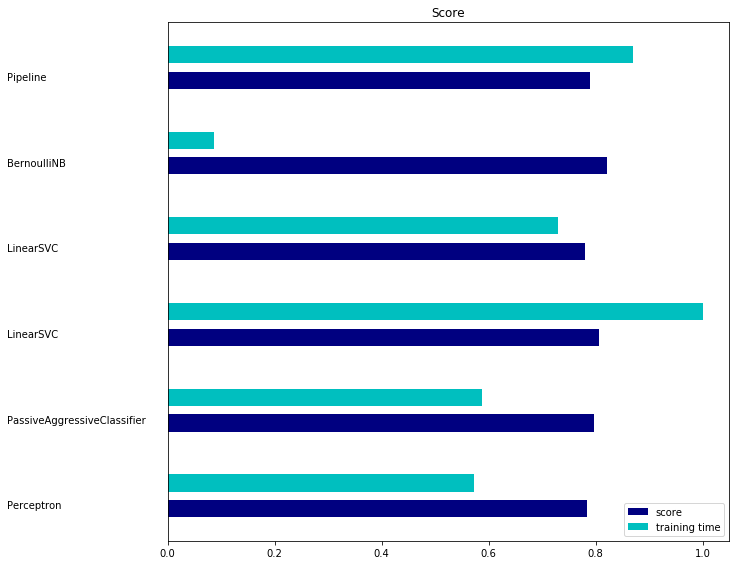

In [472]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time", color='c')
#plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [473]:
results

[['Perceptron',
  'PassiveAggressiveClassifier',
  'LinearSVC',
  'LinearSVC',
  'BernoulliNB',
  'Pipeline'],
 [0.7845151410866007,
  0.7974889734993279,
  0.80683553408781206,
  0.77976249982935797,
  0.82098030484548801,
  0.79049015801522471],
 [9.331826210021973,
  9.582099199295044,
  16.28858995437622,
  11.894047498703003,
  1.4263315200805664,
  14.181061267852783],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [453]:


# instantiate the model with the best known parameters
bestmodel = BernoulliNB(alpha=.01)
#MultinomialNB(alpha=.01)

#BernoulliNB(alpha=.01)

# train the model with X and y (not X_train and y_train)
bestmodel.fit(X_full, y)

#make a prediction for an out-of-sample observation
result = bestmodel.predict_proba(T_test)
bestmodel.predict(T_test)


array(['MWS', 'EAP', 'EAP', ..., 'EAP', 'MWS', 'HPL'], 
      dtype='<U3')

In [454]:
result

array([[  1.46890542e-03,   9.54621451e-07,   9.98530140e-01],
       [  1.00000000e+00,   6.98789498e-14,   1.11935578e-10],
       [  9.91386739e-01,   8.61326103e-03,   6.34198461e-12],
       ..., 
       [  1.00000000e+00,   1.31410821e-39,   3.47991865e-37],
       [  8.39193811e-08,   2.17103342e-14,   9.99999916e-01],
       [  9.12849470e-06,   9.99990872e-01,   1.16583445e-17]])

In [455]:
row_sums = result.sum(axis=1)
result_normalized = result / row_sums[:, np.newaxis]

In [456]:
df = pd.DataFrame(result_normalized, test_df.id, columns=["EAP","HPL","MWS"])

In [457]:
df

,EAP,HPL,MWS
id,,,
id02310,1.468905e-03,9.546215e-07,9.985301e-01
id24541,1.000000e+00,6.987895e-14,1.119356e-10
id00134,9.913867e-01,8.613261e-03,6.341985e-12
id27757,9.999996e-01,4.291592e-07,1.430701e-18
id04081,9.997175e-01,7.973623e-05,2.027168e-04
id27337,9.997798e-01,2.202250e-04,8.292513e-09
id24265,9.891319e-01,3.832495e-03,7.035569e-03
id25917,9.409388e-06,2.486244e-03,9.975043e-01
id04951,1.000000e+00,2.401499e-09,2.080020e-19


In [458]:
df.to_csv("Real2.csv")